In [5]:
# Import required libraries
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("train.csv")

# Exploratory Variable Analysis
Jordan & Joe will analyze the first 40 variables, from "MSSubClass", to "HeatingQC"
Things to keep in mind:
* Which variables should we dummify?
* How will we handle missing values?  Do we drop the row, impute using the mean, or use kNN?
* Do any of the features look skewed?  Should we transform them using Box-Cox, log, sqrt?
* Quick correlation plots.  Variables with high corrleation to prices should be prioritized as predictors
* How to deal with outliers?
* How to deal with multi-collinearity?

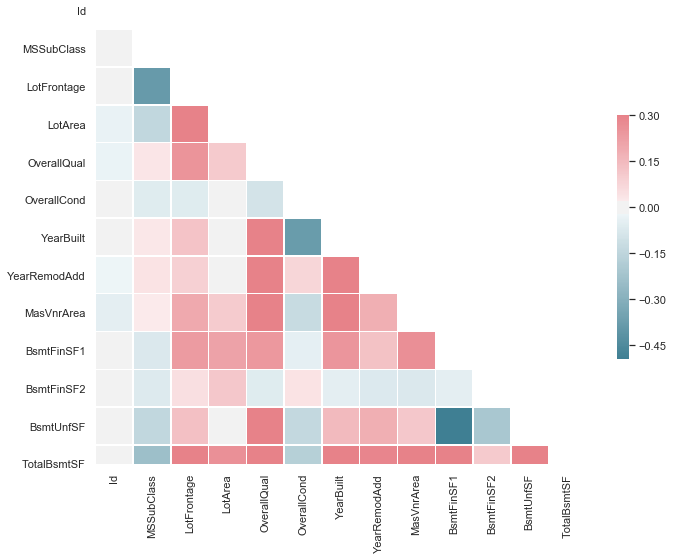

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check Correlations Between Variables
from string import ascii_letters
sns.set(style="white")
# Compute the correlation matrix
corr = df.iloc[:,0:40].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [3]:
# We have 80 columns (79 predictors, 1 response variable) and 1,459 observations
df.shape

(1460, 81)

In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
def EDA_categorical(df, series_name):
    print("Number of missing values: ", df[series_name].isna().sum())
    print("")
    print("Unique values and their frequencies:")
    print(df[series_name].value_counts(sort = True))
    print("")
    print("Mean SalePrice in different groups of",series_name)
    print(df.groupby(series_name)["SalePrice"].mean().sort_values(ascending=False))

In [6]:
def EDA_numeric(df, series_name):
    print("Number of missing values: ", df[series_name].isna().sum())
    print("")
    print("Quantile analysis:")
    print(df[series_name].describe())
    print("")
    print("Correlation with housing prices:")
    print(round(df[series_name].corr(df["SalePrice"]),2))

# Variable 1: MSSubClass (Identifies the type of dwelling involved in the sale.)

In [7]:
EDA_categorical(df, "MSSubClass")

Number of missing values:  0

Unique values and their frequencies:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Mean SalePrice in different groups of MSSubClass
MSSubClass
60     239948.501672
120    200779.080460
75     192437.500000
20     185224.811567
80     169736.551724
70     166772.416667
40     156125.000000
85     147810.000000
50     143302.972222
160    138647.380952
90     133541.076923
190    129613.333333
45     108591.666667
180    102300.000000
30      95829.724638
Name: SalePrice, dtype: float64


### Resolve Conflicts between MSSubClass & HouseStyle

In [8]:
# Define two auxiliary functions to help us comb through this data
#   to find conflicts between the labels of the columns "MSSubClass" and "HouseStyle"
def HouseStyle_Value_Count_for_MSSubClass(df, MSSubClass_label, description):
    print("")
    print("#"*75)
    print("For MSSubClass =",MSSubClass_label,"(",description,")","\nThe values & frequencies of HouseStyle are:")
    print(df.loc[df["MSSubClass"]==MSSubClass_label,"HouseStyle"].value_counts())
    print("")

def Find_MSSubClass_HouseStyle_Conflict(df, MSSubClass_label, HouseStyle_label):
    rows_with_conflict = (df["MSSubClass"]==MSSubClass_label) & (df["HouseStyle"]==HouseStyle_label)
    if (sum(rows_with_conflict) >= 1):
        print("Grabbing problematic observations where MSSubClass =",MSSubClass_label,"but","HouseStyle =", HouseStyle_label,"...")
    else:
        raise ValueError("No rows matching this criterion!")
    return rows_with_conflict

In [9]:
# MSSubClass = 20: 1-STORY 1946 & NEWER ALL STYLES
HouseStyle_Value_Count_for_MSSubClass(df, 20, "1-STORY 1946 & NEWER ALL STYLES")
mask_1 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "2Story")
mask_2 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "SLvl")

# MSSubClass = 30: 1-STORY 1945 & OLDER
HouseStyle_Value_Count_for_MSSubClass(df, 30, "1-STORY 1945 & OLDER")
mask_3 = Find_MSSubClass_HouseStyle_Conflict(df, 30, "1.5Fin")
mask_4 = Find_MSSubClass_HouseStyle_Conflict(df, 30, "1.5Unf")

# MSSubClass = 40: 1-STORY W/FINISHED ATTIC ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 40, "1-STORY W/FINISHED ATTIC ALL AGES")

# MSSubClass = 45: 1-1/2 STORY - UNFINISHED ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 45, "1-1/2 STORY - UNFINISHED ALL AGES")

# MSSubClass = 50: 1-1/2 STORY FINISHED ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 50, "1-1/2 STORY FINISHED ALL AGES")
mask_5 = Find_MSSubClass_HouseStyle_Conflict(df, 50, "2Story")

# MSSubClass = 60: 2-STORY 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 60, "2-STORY 1946 & NEWER")
mask_6 = Find_MSSubClass_HouseStyle_Conflict(df, 60, "SLvl")

# MSSubClass = 70: 2-STORY 1945 & OLDER
HouseStyle_Value_Count_for_MSSubClass(df, 70, "2-STORY 1945 & OLDER")
mask_7 = Find_MSSubClass_HouseStyle_Conflict(df, 70, "2.5Fin")

# MSSubClass = 75: 2-1/2 STORY ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 75, "2-1/2 STORY ALL AGES")
mask_8 = Find_MSSubClass_HouseStyle_Conflict(df, 75, "2Story")

# MSSubClass = 80: SPLIT OR MULTI-LEVEL
HouseStyle_Value_Count_for_MSSubClass(df, 80, "SPLIT OR MULTI-LEVEL")

# MSSubClass = 85: SPLIT FOYER
HouseStyle_Value_Count_for_MSSubClass(df, 85, "SPLIT FOYER")

# MSSubClass = 90: DUPLEX - ALL STYLES AND AGES
HouseStyle_Value_Count_for_MSSubClass(df, 90, "DUPLEX - ALL STYLES AND AGES")
print("??? I need to do more research on Duplexes...how many floors should they have???")

# MSSubClass = 120: 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 120, "1-STORY PUD (Planned Unit Development) - 1946 & NEWER")
mask_9 = Find_MSSubClass_HouseStyle_Conflict(df, 120, "SFoyer")

# MSSubClass = 150: 1-1/2 STORY PUD - ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 150, "1-1/2 STORY PUD - ALL AGES")
print("How many rows have MSSubClass = 150?",sum(df["MSSubClass"] == 150))

# MSSubClass = 160: 2-STORY PUD - 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 160, "2-STORY PUD - 1946 & NEWER")

# MSSubClass = 180: PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
HouseStyle_Value_Count_for_MSSubClass(df, 180, "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER")

# MSSubClass = 190: 2 FAMILY CONVERSION - ALL STYLES AND AGES
HouseStyle_Value_Count_for_MSSubClass(df, 190, "2 FAMILY CONVERSION - ALL STYLES AND AGES")
print("??? I need to do more research on 2-family conversion...what does this mean???")

# We can dummify these types of dwellings, or we can just make dummy variables indicating
#   "Yes, 1946 and newer" vs. "No, 1945 and older" because this information is really important
#   But we don't have it for every single type of MSSubClass
print("Potential solution:")
print("(1) Throw out observations with type conflicts found in these boolean masks")
print("(2) Then dummify the MSSubClass")
print("??? How do we dummify MSSubClass???")


###########################################################################
For MSSubClass = 20 ( 1-STORY 1946 & NEWER ALL STYLES ) 
The values & frequencies of HouseStyle are:
1Story    534
2Story      1
SLvl        1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = 2Story ...
Grabbing problematic observations where MSSubClass = 20 but HouseStyle = SLvl ...

###########################################################################
For MSSubClass = 30 ( 1-STORY 1945 & OLDER ) 
The values & frequencies of HouseStyle are:
1Story    67
1.5Unf     1
1.5Fin     1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 30 but HouseStyle = 1.5Fin ...
Grabbing problematic observations where MSSubClass = 30 but HouseStyle = 1.5Unf ...

###########################################################################
For MSSubClass = 40 ( 1-STORY W/FINISHED ATTIC ALL AGES ) 
The values & frequencies of HouseStyle a

# Variable 2: MSZoning (Identifies the general zoning classification of the sale.)

In [10]:
EDA_categorical(df, "MSZoning")

Number of missing values:  0

Unique values and their frequencies:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Mean SalePrice in different groups of MSZoning
MSZoning
FV         214014.061538
RL         191004.994787
RH         131558.375000
RM         126316.830275
C (all)     74528.000000
Name: SalePrice, dtype: float64


# Variable 3: LotFrontage (Linear feet of street connected to property)

In [11]:
EDA_numeric(df, "LotFrontage")

Number of missing values:  259

Quantile analysis:
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Correlation with housing prices:
0.35


In [12]:
print("There is so much data missing: 259 observations missing out of 1,460...")
print("??? What should we do with this???")

There is so much data missing: 259 observations missing out of 1,460...
??? What should we do with this???


# Variable 4: LotArea (Lot size in square feet)

In [13]:
EDA_numeric(df, "LotArea")

Number of missing values:  0

Quantile analysis:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Correlation with housing prices:
0.26


In [14]:
# The square root of "LotArea" should be highly correlated to "LotFrontage"
print("Correlation of lot area square rooted vs. length of property touching street:")
print(round(df["LotFrontage"].corr(df["LotArea"]**0.5),2))
print("")

# Maybe we can just drop LotFrontage, then?
print("??? One thing that we can try is using feature selection like Lasso to decide if we should include LotFrontage, when we already have LotArea???")

Correlation of lot area square rooted vs. length of property touching street:
0.6

??? One thing that we can try is using feature selection like Lasso to decide if we should include LotFrontage, when we already have LotArea???


# Variable 5: Street (Type of road access to property)

In [15]:
EDA_categorical(df, "Street")

Number of missing values:  0

Unique values and their frequencies:
Pave    1454
Grvl       6
Name: Street, dtype: int64

Mean SalePrice in different groups of Street
Street
Pave    181130.538514
Grvl    130190.500000
Name: SalePrice, dtype: float64


In [16]:
print("There are a lot of variables in here with semi-decent predictive power, but if we include all of them, it will cause a lot of issues with multi-collinearity")
print("")
print("One option is: we can rank the variables based on their correlation to housing prices, and drop the ones with the lowest to start with")
print("???")

There are a lot of variables in here with semi-decent predictive power, but if we include all of them, it will cause a lot of issues with multi-collinearity

One option is: we can rank the variables based on their correlation to housing prices, and drop the ones with the lowest to start with
???


# Variable 6: Alley (Type of alley access to property)

In [17]:
EDA_categorical(df, "Alley")

Number of missing values:  1369

Unique values and their frequencies:
Grvl    50
Pave    41
Name: Alley, dtype: int64

Mean SalePrice in different groups of Alley
Alley
Pave    168000.585366
Grvl    122219.080000
Name: SalePrice, dtype: float64


In [18]:
print("1369 out of 1,460 missing...I vote to drop this variable completely")

1369 out of 1,460 missing...I vote to drop this variable completely


# Variable 7: LotShape (General shape of property)

In [19]:
EDA_categorical(df, "LotShape")

Number of missing values:  0

Unique values and their frequencies:
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Mean SalePrice in different groups of LotShape
LotShape
IR2    239833.365854
IR3    216036.500000
IR1    206101.665289
Reg    164754.818378
Name: SalePrice, dtype: float64


In [20]:
print("I don't see a strong reason to include this one...what do you think?")

I don't see a strong reason to include this one...what do you think?


# Variable 8: LandContour (Flatness of the property)

In [21]:
EDA_categorical(df, "LandContour")

Number of missing values:  0

Unique values and their frequencies:
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Mean SalePrice in different groups of LandContour
LandContour
HLS    231533.940000
Low    203661.111111
Lvl    180183.746758
Bnk    143104.079365
Name: SalePrice, dtype: float64


In [22]:
print("For variables like this, where we are not missing any values, we can easily dummify them and include them in our model, but the number of variables quickly explodes.  Let's say that we have 50 variables that are categorical, each with 5 different unique numbers, then dummification will produce 250 total features, compared to 1,460 observations, which makes it very hard to invert matrices when finding the normal equation")

For variables like this, where we are not missing any values, we can easily dummify them and include them in our model, but the number of variables quickly explodes.  Let's say that we have 50 variables that are categorical, each with 5 different unique numbers, then dummification will produce 250 total features, compared to 1,460 observations, which makes it very hard to invert matrices when finding the normal equation


# Variable 9: Utilities (Type of utilities available)

In [23]:
EDA_categorical(df, "Utilities")

Number of missing values:  0

Unique values and their frequencies:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Mean SalePrice in different groups of Utilities
Utilities
AllPub    180950.95682
NoSeWa    137500.00000
Name: SalePrice, dtype: float64


In [24]:
print("Drop variable for sure")

Drop variable for sure


# Variable 10: LotConfig (Lot configuration)

In [25]:
EDA_categorical(df, "LotConfig")

Number of missing values:  0

Unique values and their frequencies:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Mean SalePrice in different groups of LotConfig
LotConfig
CulDSac    223854.617021
FR3        208475.000000
Corner     181623.425856
FR2        177934.574468
Inside     176938.047529
Name: SalePrice, dtype: float64


In [26]:
# I think this is an important feature because usually Cul-de-sac houses are more expensive

# Variable 11: LandSlope

In [27]:
# Isn't LandContour same thing as LandSlope?  Their correlation is probably very high
# Here is a post on correlations between categorical variables:
#   https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# Shall we test here and see if these two are redundant???

In [28]:
EDA_categorical(df, "LandSlope")

Number of missing values:  0

Unique values and their frequencies:
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Mean SalePrice in different groups of LandSlope
LandSlope
Sev    204379.230769
Mod    196734.138462
Gtl    179956.799566
Name: SalePrice, dtype: float64


# Variable 12: Neighborhood (Physical locations within Ames city limits)

In [29]:
EDA_categorical(df, "Neighborhood")

Number of missing values:  0

Unique values and their frequencies:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Mean SalePrice in different groups of Neighborhood
Neighborhood
NoRidge    335295.317073
NridgHt    316270.623377
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Somerst    225379.837209
ClearCr    212565.428571
Crawfor    210624.725490
CollgCr    197965.773333
Blmngtn    194870.882353
Gilbert    192854.506329
NWAmes     189050.068493
SawyerW    186555.796610
Mitchel    156270.122449
NAmes      145847.080000
NPkVill    142694.444444
SWISU      142591.360000
Blueste    137500.000000
Sawyer    

In [30]:
# I have no doubt that this variable is very important for predicting housing prices

# Variable 13: Condition1 (Proximity to various conditions)

In [31]:
EDA_categorical(df, "Condition1")

Number of missing values:  0

Unique values and their frequencies:
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Mean SalePrice in different groups of Condition1
Condition1
PosA      225875.000000
PosN      215184.210526
RRNn      212400.000000
RRNe      190750.000000
Norm      184495.492063
RRAn      184396.615385
Feedr     142475.481481
RRAe      138400.000000
Artery    135091.666667
Name: SalePrice, dtype: float64


In [32]:
# It seems to me like the most common non-normal ones, like "near Feedr" depress housing prices

# Variable 14: Condition2 (Proximity to various conditions if more than one is present)

In [33]:
EDA_categorical(df, "Condition2")

Number of missing values:  0

Unique values and their frequencies:
Norm      1445
Feedr        6
RRNn         2
Artery       2
PosN         2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

Mean SalePrice in different groups of Condition2
Condition2
PosA      325000.000000
PosN      284875.000000
RRAe      190000.000000
Norm      181169.405536
RRAn      136905.000000
Feedr     121166.666667
Artery    106500.000000
RRNn       96750.000000
Name: SalePrice, dtype: float64


In [34]:
# I don't really get this variable and it doesn't have a lot of observations in most subclasses

# Variable 15: BldgType (Type of dwelling)

In [35]:
EDA_categorical(df, "BldgType")

Number of missing values:  0

Unique values and their frequencies:
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Mean SalePrice in different groups of BldgType
BldgType
1Fam      185763.807377
TwnhsE    181959.342105
Twnhs     135911.627907
Duplex    133541.076923
2fmCon    128432.258065
Name: SalePrice, dtype: float64


In [36]:
# Looks like a useful variable

# Variable 16: HouseStyle

In [37]:
EDA_categorical(df, "HouseStyle")

Number of missing values:  0

Unique values and their frequencies:
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Mean SalePrice in different groups of HouseStyle
HouseStyle
2.5Fin    220000.000000
2Story    210051.764045
1Story    175985.477961
SLvl      166703.384615
2.5Unf    157354.545455
1.5Fin    143116.740260
SFoyer    135074.486486
1.5Unf    110150.000000
Name: SalePrice, dtype: float64


In [38]:
# This variable looks super important

# Variable 17: OverallQual (Rates the overall material and finish of the house)

In [39]:
EDA_numeric(df, "OverallQual")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

Correlation with housing prices:
0.79


In [40]:
# Very strong correlation.  Absolutely keep this variable

# Variable 18: OverallCond (Rates the overall condition of the house)

In [41]:
EDA_numeric(df, "OverallCond")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

Correlation with housing prices:
-0.08


In [42]:
EDA_categorical(df, "OverallCond")

Number of missing values:  0

Unique values and their frequencies:
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

Mean SalePrice in different groups of OverallCond
OverallCond
9    216004.545455
5    203146.914738
7    158145.487805
8    155651.736111
6    153961.591270
2    141986.400000
4    120438.438596
3    101929.400000
1     61000.000000
Name: SalePrice, dtype: float64


In [43]:
# This is very strange...why is this happening?  How can this be so weak?  Do we have outliers???

# Variable 19: YearBuilt (Original construction date)

In [44]:
EDA_numeric(df, "YearBuilt")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Correlation with housing prices:
0.52


In [45]:
# Very strong variable, keep it
# Also, we can drop MSSubClass, because MSSubClass has same info as HouseStyle + YearBuilt

# Variable 20: YearRemodAdd

In [46]:
EDA_numeric(df, "YearRemodAdd")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

Correlation with housing prices:
0.51


In [47]:
df["YearRemodAdd"].corr(df["YearBuilt"])

0.5928549763436505

In [48]:
# Should we include both YearRemodAdd and YearBuilt???

# Variable 21: RoofStyle

In [49]:
EDA_categorical(df, "RoofStyle")

Number of missing values:  0

Unique values and their frequencies:
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

Mean SalePrice in different groups of RoofStyle
RoofStyle
Shed       225000.000000
Hip        218876.933566
Flat       194690.000000
Mansard    180568.428571
Gable      171483.956179
Gambrel    148909.090909
Name: SalePrice, dtype: float64


In [50]:
# I need more context on this one

# Variable 22: RoofMatl

In [51]:
EDA_categorical(df, "RoofMatl")

Number of missing values:  0

Unique values and their frequencies:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

Mean SalePrice in different groups of RoofMatl
RoofMatl
WdShngl    390250.000000
Membran    241500.000000
WdShake    241400.000000
Tar&Grv    185406.363636
Metal      180000.000000
CompShg    179803.679219
ClyTile    160000.000000
Roll       137000.000000
Name: SalePrice, dtype: float64


In [52]:
# Looks like a strong predictor

# Variable 23: Exterior1st

In [53]:
EDA_categorical(df, "Exterior1st")

Number of missing values:  0

Unique values and their frequencies:
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

Mean SalePrice in different groups of Exterior1st
Exterior1st
ImStucc    262000.000000
Stone      258500.000000
CemntBd    231690.655738
VinylSd    213732.900971
BrkFace    194573.000000
Plywood    175942.379630
HdBoard    163077.450450
Stucco     162990.000000
WdShing    150655.076923
Wd Sdng    149841.645631
MetalSd    149422.177273
AsbShng    107385.550000
CBlock     105000.000000
AsphShn    100000.000000
BrkComm     71000.000000
Name: SalePrice, dtype: float64


# Variable 24: Exterior2nd

In [54]:
EDA_categorical(df, "Exterior2nd")

Number of missing values:  0

Unique values and their frequencies:
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

Mean SalePrice in different groups of Exterior2nd
Exterior2nd
Other      319000.000000
ImStucc    252070.000000
CmentBd    230093.833333
VinylSd    214432.460317
BrkFace    195818.000000
Plywood    168112.387324
HdBoard    167661.565217
Wd Shng    161328.947368
Stone      158224.800000
Stucco     155905.153846
MetalSd    149803.172897
Wd Sdng    148386.065990
AsphShn    138000.000000
Brk Cmn    126714.285714
AsbShng    114060.550000
CBlock     105000.000000
Name: SalePrice, dtype: float64


In [55]:
# How do we deal with the high correlation between these two variables?
df[["Exterior1st", "Exterior2nd"]].head(n=10)

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
3,Wd Sdng,Wd Shng
4,VinylSd,VinylSd
5,VinylSd,VinylSd
6,VinylSd,VinylSd
7,HdBoard,HdBoard
8,BrkFace,Wd Shng
9,MetalSd,MetalSd


# Variable 25: MasVnrType (Masonry veneer type)

In [56]:
EDA_categorical(df, "MasVnrType")

Number of missing values:  8

Unique values and their frequencies:
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Mean SalePrice in different groups of MasVnrType
MasVnrType
Stone      265583.625000
BrkFace    204691.871910
None       156221.891204
BrkCmn     146318.066667
Name: SalePrice, dtype: float64


# Variable 26: MasVnrArea (Masonry veneer area in square feet)

In [57]:
EDA_numeric(df, "MasVnrArea")

Number of missing values:  8

Quantile analysis:
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Correlation with housing prices:
0.48


In [58]:
df["MasVnrArea"].corr(df["LotArea"])

0.10415982154021274

In [59]:
# We might want to keep this variable as well

# Variable 27: ExterQual

In [60]:
EDA_categorical(df, "ExterQual")

Number of missing values:  0

Unique values and their frequencies:
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Mean SalePrice in different groups of ExterQual
ExterQual
Ex    367360.961538
Gd    231633.510246
TA    144341.313466
Fa     87985.214286
Name: SalePrice, dtype: float64


In [61]:
# Very strong predictor

# Variable 28: ExterCond

In [62]:
EDA_categorical(df, "ExterCond")

Number of missing values:  0

Unique values and their frequencies:
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

Mean SalePrice in different groups of ExterCond
ExterCond
Ex    201333.333333
TA    184034.896256
Gd    168897.568493
Fa    102595.142857
Po     76500.000000
Name: SalePrice, dtype: float64


In [63]:
# Strong predictor

# Variable 29: Foundation

In [64]:
EDA_categorical(df, "Foundation")

Number of missing values:  0

Unique values and their frequencies:
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

Mean SalePrice in different groups of Foundation
Foundation
PConc     225230.442040
Wood      185666.666667
Stone     165959.166667
CBlock    149805.714511
BrkTil    132291.075342
Slab      107365.625000
Name: SalePrice, dtype: float64


In [65]:
# Strong predictor

# Variable 30: BsmtQual (height of basement)

In [66]:
EDA_categorical(df, "BsmtQual")

Number of missing values:  37

Unique values and their frequencies:
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

Mean SalePrice in different groups of BsmtQual
BsmtQual
Ex    327041.041322
Gd    202688.478964
TA    140759.818182
Fa    115692.028571
Name: SalePrice, dtype: float64


In [67]:
# Strong predictor, and we can convert this into a continuous variable because it is an ordinal categorical variable

# Variable 31: BsmtCond (Evaluates the general condition of the basement)

In [68]:
EDA_categorical(df, "BsmtCond")

Number of missing values:  37

Unique values and their frequencies:
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

Mean SalePrice in different groups of BsmtCond
BsmtCond
Gd    213599.907692
TA    183632.620900
Fa    121809.533333
Po     64000.000000
Name: SalePrice, dtype: float64


In [69]:
# Variable should probably be dropped because most are TA, and there are 37 missing variables

# Variable 32: BsmtExposure (Refers to walkout or garden level walls)

In [70]:
EDA_categorical(df, "BsmtExposure")

Number of missing values:  38

Unique values and their frequencies:
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Mean SalePrice in different groups of BsmtExposure
BsmtExposure
Gd    257689.805970
Av    206643.420814
Mn    192789.657895
No    165652.295908
Name: SalePrice, dtype: float64


In [71]:
# Strong variable for predictions, but there are 38 missing values.  Should we try to just impute using median of "No"?

# Variable 33: BsmtFinType1 (Rating of basement finished area)

In [72]:
EDA_categorical(df, "BsmtFinType1")

Number of missing values:  37

Unique values and their frequencies:
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Mean SalePrice in different groups of BsmtFinType1
BsmtFinType1
GLQ    235413.720096
Unf    170670.576744
ALQ    161573.068182
LwQ    151852.702703
BLQ    149493.655405
Rec    146889.248120
Name: SalePrice, dtype: float64


In [73]:
# Strong predictor.  We can convert this into a continuous variable perhaps

# Variable 34: BsmtFinSF1 (Type 1 finished square feet)

In [74]:
EDA_numeric(df, "BsmtFinSF1")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

Correlation with housing prices:
0.39


In [75]:
# We can include this one, I think

# Variable 35: BsmtFinType2 (Rating of basement finished area)

In [76]:
EDA_categorical(df, "BsmtFinType2")

Number of missing values:  38

Unique values and their frequencies:
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Mean SalePrice in different groups of BsmtFinType2
BsmtFinType2
ALQ    209942.105263
Unf    184694.690287
GLQ    180982.142857
Rec    164917.129630
LwQ    164364.130435
BLQ    151101.000000
Name: SalePrice, dtype: float64


In [77]:
# Should we drop this?

# Variable 36: BsmtFinSF2 (Type 2 finished square feet)

In [78]:
EDA_numeric(df, "BsmtFinSF2")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

Correlation with housing prices:
-0.01


In [79]:
# This should be thrown out because it looks like most observations here are 0

# Variable 37: BsmtUnfSF (Unfinished square feet of basement area)

In [80]:
EDA_numeric(df, "BsmtUnfSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

Correlation with housing prices:
0.21


In [81]:
# Potentially useful variable, though not very convincing

# Variable 38: TotalBsmtSF (Total square feet of basement area)

In [82]:
EDA_numeric(df, "TotalBsmtSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

Correlation with housing prices:
0.61


In [83]:
# Very strong predictor

# Variable 39: Heating (Type of heating)

In [84]:
EDA_categorical(df, "Heating")

Number of missing values:  0

Unique values and their frequencies:
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Mean SalePrice in different groups of Heating
Heating
GasA     182021.195378
GasW     166632.166667
OthW     125750.000000
Wall      92100.000000
Grav      75271.428571
Floor     72500.000000
Name: SalePrice, dtype: float64


In [12]:
df.groupby("Heating")["YearBuilt"].aggregate("median").sort_values(ascending=False)

Heating
GasA     1974.0
Wall     1949.0
Floor    1949.0
Grav     1926.0
GasW     1918.5
OthW     1894.5
Name: YearBuilt, dtype: float64

In [85]:
# Probably not that important, considering 1428 out of 1460 have the same classification

# Variable 40: HeatingQC (Heating quality and condition)

In [86]:
EDA_categorical(df, "HeatingQC")

Number of missing values:  0

Unique values and their frequencies:
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

Mean SalePrice in different groups of HeatingQC
HeatingQC
Ex    214914.429150
Gd    156858.871369
TA    142362.876168
Fa    123919.489796
Po     87000.000000
Name: SalePrice, dtype: float64


In [87]:
# Strong predictor, we definitely need this predictor, I think

# Variable 41: CentralAir

In [88]:
EDA_categorical(df, "CentralAir")

Number of missing values:  0

Unique values and their frequencies:
Y    1365
N      95
Name: CentralAir, dtype: int64

Mean SalePrice in different groups of CentralAir
CentralAir
Y    186186.709890
N    105264.073684
Name: SalePrice, dtype: float64


# Variable 42: Electrical

In [89]:
EDA_categorical(df, "Electrical")

Number of missing values:  1

Unique values and their frequencies:
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Mean SalePrice in different groups of Electrical
Electrical
SBrkr    186825.113193
FuseA    122196.893617
FuseF    107675.444444
FuseP     97333.333333
Mix       67000.000000
Name: SalePrice, dtype: float64


In [13]:
df.groupby("Electrical")["YearBuilt"].aggregate("median").sort_values(ascending=False)

Electrical
SBrkr    1977
FuseA    1941
FuseF    1940
FuseP    1925
Mix      1920
Name: YearBuilt, dtype: int64

# Variable 43: 1stFlrSF

In [90]:
EDA_numeric(df, "1stFlrSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

Correlation with housing prices:
0.61


# Variable 44: 2ndFlrSF

In [91]:
EDA_numeric(df, "2ndFlrSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

Correlation with housing prices:
0.32


# Variable 45: LowQualFinSF

In [92]:
EDA_numeric(df, "LowQualFinSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

Correlation with housing prices:
-0.03


# Variable 46: GrLivArea

In [93]:
EDA_numeric(df, "GrLivArea")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Correlation with housing prices:
0.71


# Variable 47: BsmtFullBath

In [94]:
EDA_numeric(df, "BsmtFullBath")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.425342
std         0.518911
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

Correlation with housing prices:
0.23


# Variable 48: BsmtHalfBath

In [95]:
EDA_numeric(df, "BsmtHalfBath")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.057534
std         0.238753
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

Correlation with housing prices:
-0.02


# Variable 49: FullBath

In [96]:
EDA_numeric(df, "FullBath")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

Correlation with housing prices:
0.56


# Variable 50: HalfBath

In [97]:
EDA_numeric(df, "HalfBath")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64

Correlation with housing prices:
0.28


# Variable 51: BedroomAbvGr

In [98]:
EDA_numeric(df, "BedroomAbvGr")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

Correlation with housing prices:
0.17


# Variable 52: KitchenAbvGr

In [99]:
EDA_numeric(df, "KitchenAbvGr")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

Correlation with housing prices:
-0.14


# Variable 53: KitchenQual

In [101]:
EDA_categorical(df, "KitchenQual")

Number of missing values:  0

Unique values and their frequencies:
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Mean SalePrice in different groups of KitchenQual
KitchenQual
Ex    328554.670000
Gd    212116.023891
TA    139962.511565
Fa    105565.205128
Name: SalePrice, dtype: float64


# Variable 54: TotRmsAbvGrd

In [102]:
EDA_numeric(df, "TotRmsAbvGrd")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

Correlation with housing prices:
0.53


# Variable 55: Functional

In [103]:
EDA_categorical(df, "Functional")

Number of missing values:  0

Unique values and their frequencies:
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Mean SalePrice in different groups of Functional
Functional
Typ     183429.147059
Mod     168393.333333
Maj1    153948.142857
Min1    146385.483871
Min2    144240.647059
Sev     129000.000000
Maj2     85800.000000
Name: SalePrice, dtype: float64


# Variable 56: Fireplaces

In [104]:
EDA_numeric(df, "Fireplaces")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

Correlation with housing prices:
0.47


# Variable 57: FireplaceQu

In [105]:
EDA_categorical(df, "FireplaceQu")

Number of missing values:  690

Unique values and their frequencies:
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Mean SalePrice in different groups of FireplaceQu
FireplaceQu
Ex    337712.500000
Gd    226351.415789
TA    205723.488818
Fa    167298.484848
Po    129764.150000
Name: SalePrice, dtype: float64


# Variable 58: GarageType

In [106]:
EDA_categorical(df, "GarageType")

Number of missing values:  81

Unique values and their frequencies:
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Mean SalePrice in different groups of GarageType
GarageType
BuiltIn    254751.738636
Attchd     202892.656322
Basment    160570.684211
2Types     151283.333333
Detchd     134091.162791
CarPort    109962.111111
Name: SalePrice, dtype: float64


# Variable 59: GarageYrBlt

In [107]:
#####
EDA_categorical(df, "GarageYrBlt")

Number of missing values:  81

Unique values and their frequencies:
2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
1977.0    35
1998.0    31
1999.0    30
2008.0    29
1976.0    29
2000.0    27
2002.0    26
1968.0    26
1950.0    24
1993.0    22
2009.0    21
1965.0    21
1966.0    21
1962.0    21
1958.0    21
2001.0    20
1996.0    20
1957.0    20
1970.0    20
1960.0    19
1997.0    19
1978.0    19
1954.0    19
1974.0    18
1994.0    18
          ..
1922.0     5
1936.0     5
1916.0     5
1931.0     4
1945.0     4
1935.0     4
1928.0     4
1946.0     4
1982.0     4
1938.0     3
1921.0     3
1924.0     3
1910.0     3
1952.0     3
1932.0     3
2010.0     3
1923.0     3
1937.0     2
1934.0     2
1918.0     2
1947.0     2
1929.0     2
1914.0     2
1915.0     2
1942.0     2
1908.0     1
1927.0     1
1933.0     1
1900.0     1
1906.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

Mean SalePrice in different groups of GarageYrBlt
GarageYrBlt
2010.0    337874.666667
2008.0  

# Variable 60: GarageFinish

In [109]:
EDA_categorical(df, "GarageFinish")

Number of missing values:  81

Unique values and their frequencies:
Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

Mean SalePrice in different groups of GarageFinish
GarageFinish
Fin    240052.690341
RFn    202068.869668
Unf    142156.423140
Name: SalePrice, dtype: float64


# Variable 61: GarageCars

In [111]:
EDA_numeric(df, "GarageCars")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

Correlation with housing prices:
0.64


# Variable 62: GarageArea

In [113]:
EDA_numeric(df, "GarageArea")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

Correlation with housing prices:
0.62


# Variable 63: GarageQual

In [114]:
EDA_categorical(df, "GarageQual")

Number of missing values:  81

Unique values and their frequencies:
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

Mean SalePrice in different groups of GarageQual
GarageQual
Ex    241000.000000
Gd    215860.714286
TA    187489.836003
Fa    123573.354167
Po    100166.666667
Name: SalePrice, dtype: float64


# Variable 64: GarageCond

In [115]:
EDA_categorical(df, "GarageCond")

Number of missing values:  81

Unique values and their frequencies:
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Mean SalePrice in different groups of GarageCond
GarageCond
TA    187885.735294
Gd    179930.000000
Ex    124000.000000
Fa    114654.028571
Po    108500.000000
Name: SalePrice, dtype: float64


# Variable 65: PavedDrive

In [116]:
EDA_categorical(df, "PavedDrive")

Number of missing values:  0

Unique values and their frequencies:
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Mean SalePrice in different groups of PavedDrive
PavedDrive
Y    186433.973881
P    132330.000000
N    115039.122222
Name: SalePrice, dtype: float64


# Variable 66: WoodDeckSF

In [118]:
EDA_numeric(df, "WoodDeckSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

Correlation with housing prices:
0.32


# Variable 67: OpenPorchSF

In [119]:
EDA_numeric(df, "OpenPorchSF")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

Correlation with housing prices:
0.32


# Variable 68: EnclosedPorch

In [120]:
EDA_numeric(df, "EnclosedPorch")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

Correlation with housing prices:
-0.13


# Variable 69: 3SsnPorch

In [121]:
EDA_numeric(df, "3SsnPorch")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

Correlation with housing prices:
0.04


# Variable 70: ScreenPorch

In [122]:
EDA_numeric(df, "ScreenPorch")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

Correlation with housing prices:
0.11


# Variable 71: PoolArea

In [123]:
EDA_numeric(df, "PoolArea")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

Correlation with housing prices:
0.09


# Variable 72: PoolQC

In [124]:
EDA_categorical(df, "PoolQC")

Number of missing values:  1453

Unique values and their frequencies:
Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Mean SalePrice in different groups of PoolQC
PoolQC
Ex    490000
Fa    215500
Gd    201990
Name: SalePrice, dtype: int64


# Variable 73: Fence

In [126]:
EDA_categorical(df, "Fence")

Number of missing values:  1179

Unique values and their frequencies:
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Mean SalePrice in different groups of Fence
Fence
GdPrv    178927.457627
MnPrv    148751.089172
GdWo     140379.314815
MnWw     134286.363636
Name: SalePrice, dtype: float64


# Variable 74: MiscFeature

In [127]:
EDA_categorical(df, "MiscFeature")

Number of missing values:  1406

Unique values and their frequencies:
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

Mean SalePrice in different groups of MiscFeature
MiscFeature
TenC    250000.000000
Gar2    170750.000000
Shed    151187.612245
Othr     94000.000000
Name: SalePrice, dtype: float64


# Variable 75: MiscVal

In [128]:
EDA_numeric(df, "MiscVal")

Number of missing values:  0

Quantile analysis:
count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

Correlation with housing prices:
-0.02


# Variable 76: MoSold

In [129]:
EDA_categorical(df, "MoSold")

Number of missing values:  0

Unique values and their frequencies:
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

Mean SalePrice in different groups of MoSold
MoSold
9     195683.206349
11    192210.911392
12    186518.966102
7     186331.192308
8     184651.827869
1     183256.258621
3     183253.924528
10    179563.977528
2     177882.000000
6     177395.735178
5     172307.269608
4     171503.262411
Name: SalePrice, dtype: float64


# Variable 77: YrSold

In [130]:
EDA_categorical(df, "YrSold")

Number of missing values:  0

Unique values and their frequencies:
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

Mean SalePrice in different groups of YrSold
YrSold
2007    186063.151976
2006    182549.458599
2009    179432.103550
2010    177393.674286
2008    177360.838816
Name: SalePrice, dtype: float64


# Variable 78: SaleType

In [131]:
EDA_categorical(df, "SaleType")

Number of missing values:  0

Unique values and their frequencies:
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Mean SalePrice in different groups of SaleType
SaleType
New      274945.418033
Con      269600.000000
CWD      210600.000000
ConLI    200390.000000
WD       173401.836622
COD      143973.255814
ConLw    143700.000000
ConLD    138780.888889
Oth      119850.000000
Name: SalePrice, dtype: float64


# Variable 79: SaleCondition

In [132]:
EDA_categorical(df, "SaleCondition")

Number of missing values:  0

Unique values and their frequencies:
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

Mean SalePrice in different groups of SaleCondition
SaleCondition
Partial    272291.752000
Normal     175202.219533
Alloca     167377.416667
Family     149600.000000
Abnorml    146526.623762
AdjLand    104125.000000
Name: SalePrice, dtype: float64


# Variable 80: SalePrice

In [133]:
EDA_numeric(df, "SalePrice")

Number of missing values:  0

Quantile analysis:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Correlation with housing prices:
1.0
